# CR model with missingness parameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tensorflow.keras.layers import LSTM
from scipy.stats import uniform, norm, gaussian_kde
from scipy.integrate import dblquad
import random

from bayesflow.networks import InvertibleNetwork 
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # log-rate parameter k1
    k1_samples = np.random.normal(-0.75, 0.25, size=batch_size)
    # missingness parameter p
    p_samples = np.random.uniform(0, 0.8, size=batch_size)
    theta_samples = np.c_[k1_samples, p_samples]
    return theta_samples.astype(np.float32)
      
c2 = 10**(-0.75)   # fixed parameter k2=-0.75
sigma = 0.015   # noise standard deviation
n_obs = 11
time_points = np.linspace(0, 10, n_obs)

def batch_simulator(prior_samples, n_obs):
    """
    Simulate multiple CR model data sets with floor(p*n_obs) missing values and binary indicator augmentation
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim data sets, each with n_obs observations
    c1 = 10**prior_samples[:, 0]
    n_missing = np.floor(prior_samples[:, 1] * n_obs).astype(int)
    
    for m in range(n_sim):
        s = c1[m] + c2
        b = c1[m]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [4]:
summary_net = LSTM(32)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR11_missingness_par_augment01_ckpts', skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_missingness_par_augment01_ckpts\ckpt-300


## Generate test data

In [ ]:
# Generate test data
param_priors = np.array([[-0.75, 0.6], [-0.9, 0.75], [-1.1, 0.7], [-0.6, 0.3], [-0.4, 0.1]])  
x_datas = batch_simulator(param_priors, n_obs)
np.save('x_datas.npy', x_datas)

In [5]:
# Load test data
param_priors = np.array([[-0.75, 0.6], [-0.9, 0.75], [-1.1, 0.7], [-0.6, 0.3], [-0.4, 0.1]])  
x_datas = np.load("x_datas.npy")

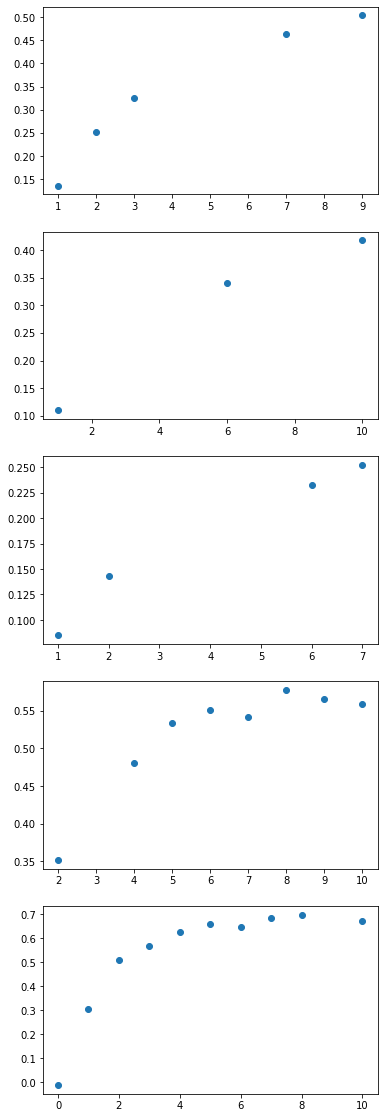

In [6]:
fig, axes = plt.subplots(5, figsize=(6,20))

for i in range(len(x_datas)):
    x_data = x_datas[i]
    time_avail = time_points[x_data[:,1]==1]
    x_avail = x_data[x_data[:,1]==1, 0]
    
    axes[i].plot(time_avail, x_avail, 'o')

## Computational faithfulness

In [7]:
# Sample from BayesFlow
n_post_samples = 2500
param_samples = amortizer.sample(x_datas, n_post_samples)

## Posterior plots

In [8]:
# Calculate analytical posteriors
def get_posterior(x_data):
    
    time_avail = time_points[x_data[:,1]==1]
    x_avail = x_data[x_data[:,1]==1, 0]
    
    def prior_eval(k1,p):   
        # Prior probability 
        return norm.pdf(k1,-0.75,0.25) * uniform.pdf(p,0,0.8)

    def likelihood(k1,p):   
        # Likelihood of the available data    
        c1 = 10**k1
        s = c1 + c2
        b = c1/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_avail)
        residual = (x_avail - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        
        n_missing = np.floor(p*n_obs)
        if n_missing == n_obs - len(time_avail):
            return np.exp(-nllh)
        else:
            return 0

    def unnormalized_posterior(k1,p):   
        # Unnormalized posterior probability conditioned on available data
        return likelihood(k1,p) * prior_eval(k1,p)
    
    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, 0, 0.8, lambda y: -2.25, lambda y: 0.75)

    posterior = lambda k1,p: unnormalized_posterior(k1,p) / scaling_factor[0]
    return posterior

posteriors = []
for x_data in x_datas:
    posteriors.append(get_posterior(x_data))

In [9]:
cmap = "viridis"

def plot_posterior(ax, posterior, param_samples, data_id, levels=None):
    mins, maxs = param_samples.min(axis=0), param_samples.max(axis=0)
    xmin, ymin = mins
    xmax, ymax = maxs
    
    # Level sets of analytic posterior distribution
    grid = 101
    A = np.linspace(xmin, xmax, grid)
    B = np.linspace(ymin, ymax, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy]) 
    if levels is not None:
        _cs = ax.contour(A, B, true_posterior, levels, cmap=cmap)
    else:
        _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.2)

    ax.set_xlabel('Parameter $k_1$')
    ax.set_ylabel('Parameter $p$')
    ax.set_title('Data set {}'.format(data_id))

In [10]:
# Select data sets for which results should be plotted
posteriors = [posteriors[0], posteriors[3], posteriors[2]]
param_samples = [param_samples[0], param_samples[3], param_samples[2]]

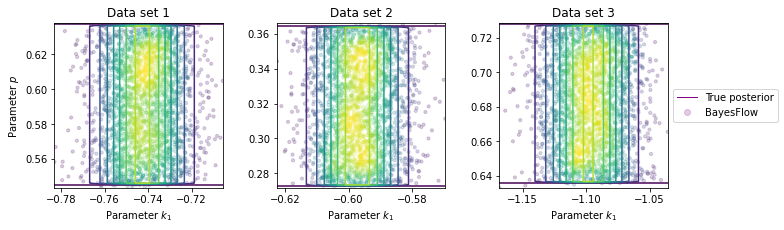

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(11, 3.3))

for j in range(len(posteriors)):
    ax = axes[j]
    plot_posterior(ax, posteriors[j], param_samples[j], j+1)
    if j == 2:
        legend_elements = [
            Line2D([0], [0], color="purple", lw=1, label="True posterior"),
            Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
        ]
        ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
    if j > 0:
        ax.set_ylabel(None) 
    
fig.tight_layout()

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/CR11_missingness_par.{fmt}", dpi=300, bbox_inches='tight')

## SBC histogram

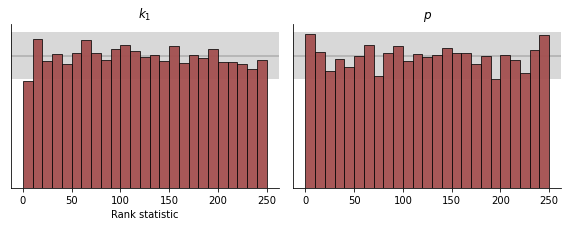

In [16]:
n_sbc = 5000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_sbc = batch_simulator(params_sbc, n_obs)
param_samples = amortizer.sample(x_sbc, n_post_samples_sbc)
f = plot_sbc(param_samples, params_sbc, param_names=['$k_1$', '$p$'])

## Error metrics

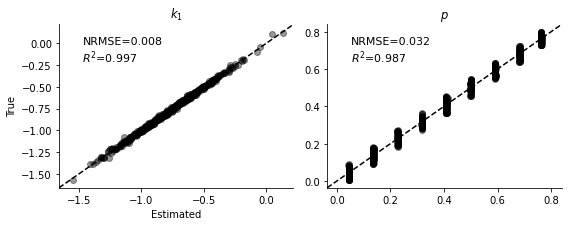

In [17]:
true_params = prior(500) 
x = batch_simulator(true_params, n_obs).astype(np.float32)
param_samples = amortizer.sample(x, n_samples=1000) 
param_means = param_samples.mean(axis=1)
f = true_vs_estimated(true_params, param_means, ['$k_1$', '$p$'])